<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Spline-fitting-with-Genetic-Algorithm" data-toc-modified-id="Spline-fitting-with-Genetic-Algorithm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Spline fitting with Genetic Algorithm</a></span><ul class="toc-item"><li><span><a href="#Selection" data-toc-modified-id="Selection-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Selection</a></span></li><li><span><a href="#Crossover-and-Mutation" data-toc-modified-id="Crossover-and-Mutation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Crossover and Mutation</a></span></li><li><span><a href="#The-procedure" data-toc-modified-id="The-procedure-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>The procedure</a></span></li></ul></li></ul></div>

In [4196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
import scipy as sp

## Spline fitting with Genetic Algorithm

Based on Yoshimoto et al. 2003 \
https://www.sciencedirect.com/science/article/pii/S001044850300006X

(-20.0, 110.0)

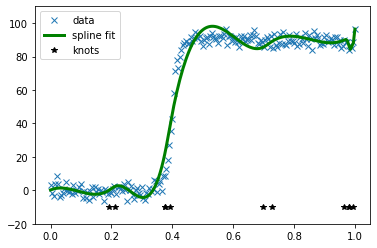

In [1090]:
x_data = np.arange(0,1.+1e-8,0.005)
N = len(x_data)
def f_Ex1 (x):
    return 90/(1+np.exp(-100*(x-0.4)))
def f_Ex2 (x):
    return np.concatenate([1/(0.01 + (x[x<0.6]-0.3)**2), 1/(0.015 + (x[x>=0.6]-0.65)**2) ],axis=0) 

y_data = f_Ex1(x_data) + np.random.randn(N)*3
# y_data = f_Ex2(x_data) + np.random.randn(N)

# plt.plot(x_data, y_data,'x')
# knots = np.array([0.1, 0.3,0.6,0.7,0.9])
knots = np.array([0.19334084, 0.2125511 , 0.37671083, 0.37756784, 0.39349249,0.69963719, 0.72624378, 0.96566566, 0.97987222, 0.9819273, 0.99267495])
knots = knots[1:]
#         0.99267495])

knots = np.array([0.19334084, 0.2125511 , 0.37671083, 0.37756784, 0.39349249,
        0.69963719, 0.72624378, 0.96566566, 0.97987222, 0.9819273 ,
        0.99267495])
m = 3 #cubic spline
spl = LSQUnivariateSpline(x_data, y_data, knots, k=m)
plt.plot(x_data, y_data,'x', label="data")
plt.plot(x_data, spl(x_data), 'g-', lw=3, label="spline fit")
plt.plot(knots, knots*0-10, "*", c="black", label="knots")
plt.legend()
plt.ylim([-20, 110])
# x_data

### Selection

In [73]:
Q  =  np.sum((y_data - spl(x_data))**2 )
n = len(knots)
BIC = N*np.log(Q) + np.log(N)*(2*n+m)

(909.7886352397177, 59.867212417845195)

In [3336]:
def selection_tournament(fits, n, k=2, elitism=True):
    """
    input: fits - the fitness of the populations
           k - size of the tournament, default is 2
           n - size of the selected individuals
    randomly select k candidates for the tournaments, pick the best
    repeat n times
    output: indexes of n selected individuals by the tournament
    """
    inds = np.arange(len(fits))
    inds_tnm = np.random.choice(inds, (n,k))
    winner_results = np.argmax(fits[inds_tnm], 1)
    inds_winner =np.choose(winner_results, inds_tnm.T)
    if elitism:
        arg_best = np.argmax(fits)
        if arg_best not in inds_winner:
            inds_winner[np.random.choice(n)] = arg_best
    return inds_winner
# selection_tournament(np.linspace(0,1,11), 10)

### Crossover and Mutation

In [230]:
def crossover(x1, x2, interval=None, range_data=[0,1]):
    """ crossover operation
    input: x1 (n,), x2 (m,) in ascending order
    given / define randomly an interval in range_data 
    swap all the array elements inside the interval of x1 with x2
    return (x1_x, x2_x)
    """
    if interval is None:
        interval = np.sort(np.random.rand(2))*(range_data[1]-range_data[0]) + range_data[0]          
    arg_range1 = np.searchsorted(x1, interval)
    arg_range2 = np.searchsorted(x2, interval)
    x1_x = np.hstack([x1[:arg_range1[0]], x2[arg_range2[0]:arg_range2[1]], x1[arg_range1[1]:]] )
    x2_x = np.hstack([x2[:arg_range2[0]], x1[arg_range1[0]:arg_range1[1]], x2[arg_range2[1]:]] )
    return [x1_x, x2_x]
# TEST
# x1 = np.linspace(0,10,11)
# x2 = np.linspace(4,7,4)+0.5
# a, b= crossover(x1,x2, None, [0,10])
# len(a)+len(b) == len(x1)+len(x2), np.sum(np.diff(a)<0), np.sum(np.diff(b)<0)

In [353]:
def mutation(x1, pm, range_data=[0,1]):
    """
    input: x1(n,) is a gene
    pm is probability of mutaion
    cycle through each element of x1: for each iteration delete it (50%) or 
    randomly create a new element (50%) with a probability pm
    output: new x1
    """
    x1_m = x1.copy()
    n = len(x1)
    bool_m = np.random.rand(n) < pm
    arg_m  = np.argwhere(bool_m)
    bool_del = np.random.rand(len(arg_m)) < 0.5
    arg_del = arg_m[bool_del]
    new_ele = np.random.rand(len(arg_m)-len(arg_del))*(range_data[1] - range_data[0]) + range_data[0]
    x1_m = np.delete(x1_m, arg_del)
    x1_m = np.sort(np.hstack([x1_m, new_ele]))
    return x1_m
# TEST 
# v = np.zeros(1000)
# for i in range(1000):
#     v[i] = len(mutation(np.linspace(0,1,100), 0.5))
# v.mean()

100.096

### The procedure

Generating the initial population

In [1091]:
L = 10 # Initial number of interior knots
K = 200 # number of individual in population 
n_generation = 100
knots_ini = np.sort(np.random.rand(K,L), axis=1)
knots_ini = knots_ini*(x_data[-1]-x_data[1])+x_data[1]
m = 3
# spl = LSQUnivariateSpline(x_data, y_data, knots, k=m)
# spls = [LSQUnivariateSpline(x_data, y_data, knots, k=m) for knots in knots_ini]
# len_knots = np.array([len(knots) for knots in knots_ini])
BICs_all = np.zeros((n_generation-1,K))
knots_all = [" "]*n_generation
knots_all[0] = knots_ini

In [1092]:
def zero_function(x):
    return x*0
def BIC_pop(knots_pop, x_data, y_data, m):
    spls = []
    for i in range(len(knots_pop)):
        try:
            spl = LSQUnivariateSpline(x_data, y_data, knots_pop[i], k=m, bbox=(0,1))
        except:
#             print("error")
            spl = zero_function
        spls += [spl]
#     spls = [LSQUnivariateSpline(x_data, y_data, knots, k=m, bbox=(0,1)) for knots in knots_pop]
    len_knots = np.array([len(knots) for knots in knots_pop])
    Qs  =  np.array([np.sum((y_data - spl(x_data))**2 ) for spl in spls])
    N = len(y_data)
    BICs = N*np.log(Qs) + np.log(N)*(2*len_knots+m+1)
    return BICs
# Qs  =  np.array([np.sum((y_data - spl(x_data))**2 ) for spl in spls])
# # n = len(knots)
# BICs = N*np.log(Qs) + np.log(N)*(2*len_knots+m)


In [1095]:
for i in range(n_generation-1):
    knots_old = knots_all[i]
    BICs = BIC_pop(knots_old, x_data, y_data, m)
    BICs_all[i] = BICs
    selected_inds = selection_tournament(-BICs, K)
    BICs = BICs[selected_inds]
    BICmean = BICs.mean(); BICmin = BICs.min()
    knots_new = []
    for j in range(0,K,2):
        BICm = np.min(BICs[j:j+2])
        pc = (BICm-BICmin)/(BICmean-BICmin) if BICm <= BICmean else 1
        if np.random.rand() < pc:
            knots_new  += crossover(knots_old[selected_inds[j]], knots_old[selected_inds[j+1]])
        else:
            knots_new += [knots_old[selected_inds[j]], knots_old[selected_inds[j+1]]]
    BICs = BIC_pop(knots_new, x_data, y_data, m)
    BICmean = BICs.mean(); BICmin = BICs.min()
    for j in range(K):
        pm = 0.5*(BICs[j]-BICmin)/(BICmean-BICmin) if BICs[j] <= BICmean else 0.5
        knots_new[j] = mutation(knots_new[j], pm)
    knots_all[i+1] = knots_new

/tmp/ipykernel_1212742/2240026594.py:11: RuntimeWarning: invalid value encountered in double_scalars
  pc = (BICm-BICmin)/(BICmean-BICmin) if BICm <= BICmean else 1
/tmp/ipykernel_1212742/2240026594.py:19: RuntimeWarning: invalid value encountered in double_scalars
  pm = 0.5*(BICs[j]-BICmin)/(BICmean-BICmin) if BICs[j] <= BICmean else 0.5


Best solution

Example 1

Text(0, 0.5, 'BIC')

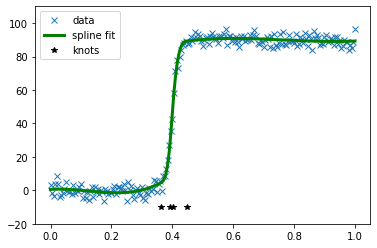

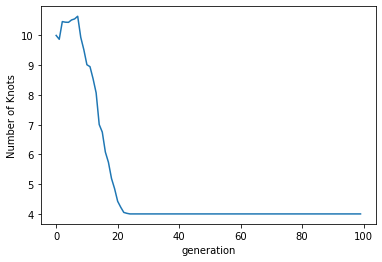

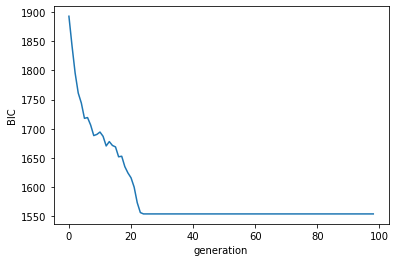

In [1097]:
arg_best = np.argmin(BICs_all[-1])
knots = knots_all[-1][arg_best]
m = 3 #cubic spline
spl = LSQUnivariateSpline(x_data, y_data, knots, k=m)
# fig, axs = plt.subplots(3, 1)
plt.figure()
# plt = axs[0]
plt.plot(x_data, y_data,'x', label="data")
plt.plot(x_data, spl(x_data), 'g-', lw=3, label="spline fit")
plt.plot(knots, knots*0-10, "*", c="black", label="knots")
plt.legend()
plt.ylim([-20, 110])

plt.figure()
len_knots = np.array([[len(knots_all[j][i]) for i in range(K) ] for j in range(n_generation)  ])
plt.plot(len_knots.mean(axis=1))
plt.xlabel("generation")
plt.ylabel("Number of Knots")

plt.figure()
# for i in range(n_generation):
#     BICs_all[i] = BIC_pop(knots_all[i], x_data, y_data, m)
plt.plot(BICs_all.mean(axis=1))
plt.xlabel("generation")
plt.ylabel("BIC")
# plt.ylim([1000,2000])

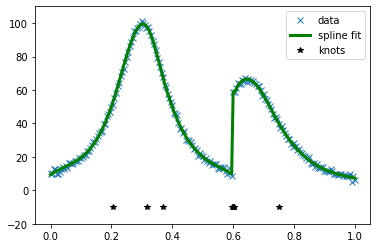

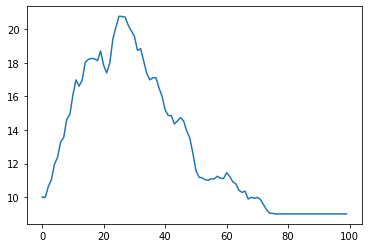

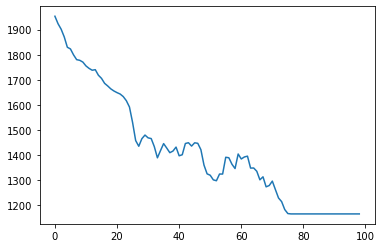

In [1089]:
arg_best = np.argmin(BICs_all[-1])
knots = knots_all[-1][arg_best]
m = 3 #cubic spline
spl = LSQUnivariateSpline(x_data, y_data, knots, k=m)
# fig, axs = plt.subplots(3, 1)
plt.figure()
# plt = axs[0]
plt.plot(x_data, y_data,'x', label="data")
plt.plot(x_data, spl(x_data), 'g-', lw=3, label="spline fit")
plt.plot(knots, knots*0-10, "*", c="black", label="knots")
plt.legend()
plt.ylim([-20, 110])

plt.figure()
len_knots = np.array([[len(knots_all[j][i]) for i in range(K) ] for j in range(n_generation)  ])
plt.plot(len_knots.mean(axis=1))

plt.figure()
# for i in range(n_generation):
#     BICs_all[i] = BIC_pop(knots_all[i], x_data, y_data, m)
plt.plot(BICs_all.mean(axis=1))
# plt.ylim([1000,2000])